## Install Libraries

In [1]:
! pip uninstall opencv-python -y
! pip uninstall opencv-contrib-python -y
! pip install opencv-python==3.4.11.45
! pip install opencv-contrib-python==3.4.11.45
! pip install tqdm

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 49.1 MB 33 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 54.7 MB 52 kB/s 


## Load Libraries

In [2]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
import scipy.misc
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import joblib

## Connect drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/')
os.getcwd()

Mounted at /content/drive/


'/content/drive/MyDrive/Colab Notebooks'

## Classifier Utils

In [54]:
def read_images(folder):
    images_gray = []
    # images_rgb = []
    images_name = []
    print("Reading and resizing images for ", os.path.split(folder)[1])
    for filename in os.listdir(folder):
        img_gray = Image.open(fp=os.path.join(folder, filename),mode='r').convert('LA')
        newsize = (96, 160)
        img_gray = img_gray.resize(newsize)
        # img_rgb = Image.open(fp=os.path.join(folder, filename),mode='r')
        images_name.append(filename)
        # if img_rgb is not None:
        #     images_rgb.append(img_rgb)
        if img_gray is not None:
            images_gray.append(img_gray)
    return images_gray, images_name
    
def calculate_Hog(listImages,label):
    if(label==1):
        print('Calculating hog for pos images')
    else:
        print('Calculating hog for neg images')
    list_fd = []
    list_hog_img = []
    list_label = []
    for img in listImages:
        fd, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        list_fd.append(fd)
        list_label.append(label)
        list_hog_img.append(hog_img)
    return list_fd, list_hog_img, list_label

def linear_svm_clf(X_input, y_output,test_input, test_output):
    print('start learning SVM.')
    lin_clf = svm.LinearSVC(max_iter=100000)
    # lin_clf = svm.LinearSVC()
    lin_clf.fit(X_input, y_output)
    print('finish learning SVM.')
    print(lin_clf.fit(X_input, y_output))
    y_pred = lin_clf.predict(test_input)
    plotConfusions(test_output, y_pred)
    joblib.dump(lin_clf, '25k_iter.pkl', compress=9)

def random_forest_clf(X_input,y_output,test_input,test_output):
    rft_clf = RandomForestClassifier(n_estimators=600)
    # Train the model using the training sets y_pred=clf.predict(X_test)
    rft_clf.fit(X_input, y_output)
    y_pred = rft_clf.predict(test_input)
    plotConfusions(test_output, y_pred)
    joblib.dump(rft_clf, 'n_400_estimator.pkl', compress=9)
    
    

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)
    class_names = ["pos", "neg"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')
    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    plt.show()
    print("\n")
    
    print("Accuracy: " + str(accuracy_score(true, predictions)))
    print(classification_report(true, predictions))
    print('\n')
    t = p = 0
    t, f = confusion_matrix(true, predictions)
    tp, fp = t
    tn, fn = f
    print("True Positive Rate: ", tp/(tp+fp))
    print("True Negative Rate: ", tn/(tn+fp))

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    # if not title:
    #     if normalize:
    #         title = 'Normalized confusion matrix'
    #     else:
    #         title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
                                                            
def load_model_plot_results(filename):
    test_posimggray, test_posimgName = read_images(test_pos_path)
    test_negimggray, test_negimgName = read_images(test_neg_path)
    test_pos_fd, test_pos_hog, test_pos_label = calculate_Hog(test_posimggray, 1)
    test_neg_fd, test_neg_hog, test_neg_label = calculate_Hog(test_negimggray, 0)
    test_input_hog = np.asarray(np.vstack((test_pos_hog, test_neg_hog)))
    test_input = np.asarray(np.vstack((test_pos_fd,test_neg_fd)))
    test_output = np.asarray(np.hstack((test_pos_label,test_neg_label)))
    loaded_model = joblib.load(filename)
    y_pred = loaded_model.predict(test_input)
    print(len(y_pred))
    i=0
    while(i<len(y_pred)):
        if(test_output[i]==1):
            plt.title('Ground Truth:' + str(test_output[i]) + ' Pridicted value :' + str(y_pred[i]))
            plt.imshow(test_input_hog[i])
            plt.show()
        #plt.savefig('FAST' + str(name))
        i+=1
    print("Accuracy: " + str(accuracy_score(test_output, y_pred)))
    print('\n')
    print(classification_report(test_output, y_pred))
    print(y_pred, test_output)

def load_model_display_matrices(filename):
    test_posimggray, test_posimgName = read_images(test_pos_path)
    test_negimggray, test_negimgName = read_images(test_neg_path)
    test_pos_fd, test_pos_hog, test_pos_label = calculate_Hog(test_posimggray, 1)
    test_neg_fd, test_neg_hog, test_neg_label = calculate_Hog(test_negimggray, 0)
    test_input_hog = np.asarray(np.vstack((test_pos_hog, test_neg_hog)))
    test_input = np.asarray(np.vstack((test_pos_fd, test_neg_fd)))
    test_output = np.asarray(np.hstack((test_pos_label, test_neg_label)))
    loaded_model = joblib.load(filename)
    y_pred = loaded_model.predict(test_input)
    print("Accuracy: " + str(accuracy_score(test_output, y_pred)))
    print('\n')
    print(classification_report(test_output, y_pred))


def classifier(model, X_input, y_output, test_input, test_output):
    if model == "svm":
      linear_svm_clf(X_input, y_output, test_input, test_output)
    elif model == "random_forest":
      random_forest_clf(X_input, y_output, test_input, test_output)



### Data Paths

In [6]:
train_pos_path = "Task1_data/INRIA_Dataset/Train/pos"
test_pos_path  = "Task1_data/INRIA_Dataset/Test/pos"
train_neg_path = "Task1_data/INRIA_Dataset/Train/neg"
test_neg_path  = "Task1_data/INRIA_Dataset/Test/neg"

In [12]:
# Read Images
train_pos_img, train_pos_img_Name = read_images(train_pos_path)
train_neg_img, train_neg_img_Name = read_images(train_neg_path)
test_pos_img, test_pos_img_Name   = read_images(test_pos_path)
test_neg_img, test_neg_img_Name   = read_images(test_neg_path)

Reading and resizing images for  pos
Reading and resizing images for  neg
Reading and resizing images for  pos
Reading and resizing images for  neg


Visualizing data frin Train
Visualizing data from Test


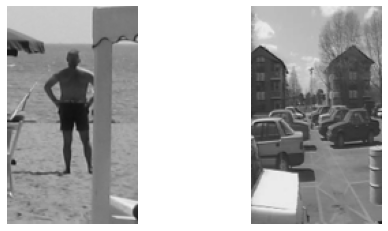

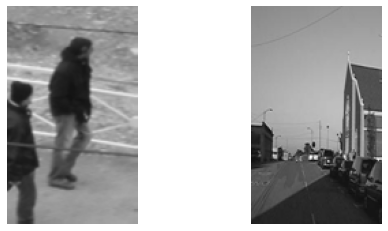

In [21]:
# visualize data
print("Visualizing data frin Train")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
# accessing Dogs category in images i.e. train set
ax1.imshow(train_pos_img[6], cmap=plt.cm.gray)

ax2.axis('off')
# accessing Cats category in images i.e. train set
ax2.imshow(train_neg_img[20], cmap=plt.cm.gray)


print("Visualizing data from Test")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
# accessing Dogs category in test i.e. test set
ax1.imshow(test_pos_img[11], cmap=plt.cm.gray)

ax2.axis('off')
# accessing Cat category in test i.e. test set
ax2.imshow(test_neg_img[13], cmap=plt.cm.gray)
#ax2.set_title('has Label ' + str(data[12502][1]))

In [23]:
# Compute HoG descriptor
train_pos_fd, train_pos_hog, pos_label    = calculate_Hog(train_pos_img, 1)
train_neg_fd, train_neg_hog, neg_label    = calculate_Hog(train_neg_img, 0)
test_pos_fd, test_pos_hog, test_pos_label = calculate_Hog(test_pos_img, 1)
test_neg_fd, test_neg_hog, test_neg_label = calculate_Hog(test_neg_img, 0)

Calculating hog for pos images
Calculating hog for neg images
Calculating hog for pos images
Calculating hog for neg images


In [25]:
# Prepare classifier inputs
X_input = np.asarray(np.vstack((train_pos_fd, train_neg_fd)))
y_output = np.asarray(np.hstack((pos_label, neg_label)))
test_input = np.asarray(np.vstack((test_pos_fd, test_neg_fd)))
test_output = np.asarray(np.hstack((test_pos_label, test_neg_label)))

## Train and validate SVM

start learning SVM.
finish learning SVM.
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Confusion matrix, without normalization
Normalized confusion matrix


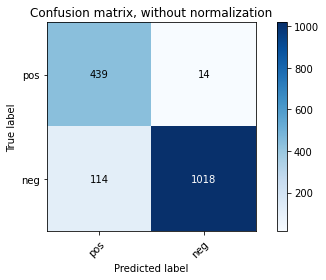

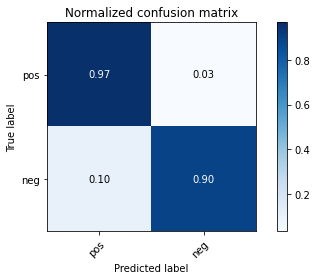



Accuracy: 0.9192429022082019
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       453
           1       0.99      0.90      0.94      1132

    accuracy                           0.92      1585
   macro avg       0.89      0.93      0.91      1585
weighted avg       0.93      0.92      0.92      1585



True Positive Rate:  0.9690949227373068
True Negative Rate:  0.890625


In [53]:
#--Call to the function containing the code for executing of svm or random forest
model = ["svm", "random_forest"]
classifier(model[0], X_input, y_output, test_input, test_output)

## Train and Validate Random forest

Confusion matrix, without normalization
Normalized confusion matrix


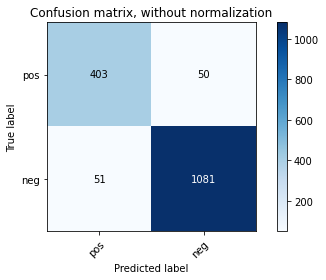

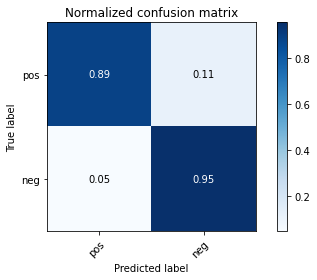



Accuracy: 0.9362776025236593
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       453
           1       0.96      0.95      0.96      1132

    accuracy                           0.94      1585
   macro avg       0.92      0.92      0.92      1585
weighted avg       0.94      0.94      0.94      1585



True Positive Rate:  0.8896247240618101
True Negative Rate:  0.504950495049505


In [55]:
# running model for random forest
classifier(model[1], X_input, y_output, test_input, test_output)